<a href="https://colab.research.google.com/github/Hritaku/ADAPTIVE-LEARNING-SYSTEMS-AUTOMATIC-STUDENT-SEGMENTATION-BASED-ON-ONLINE-COURSE-INTERACTION/blob/main/notebookb8d2a2119c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.datasets import make_classification

In [43]:
df=pd.read_csv("/kaggle/input/course-reviews-on-coursera/Coursera_reviews.csv")
df.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [44]:
# Preprocessing: Handle missing values
df.dropna(subset=['reviews', 'reviewers', 'rating'], inplace=True)

In [45]:
# Convert date to datetime
df['date_reviews'] = pd.to_datetime(df['date_reviews'])


In [46]:


# Extended Sample DataFrame
data = {
    'reviews': ['Great product!', 'Not bad', 'Could be better', 'Amazing!', 'Poor quality',
                'Fantastic!', 'Terrible service', 'Loved it!', 'Would not recommend', 'Best purchase ever!'],
    'rating': [5, 4, 3, 5, 1, 5, 1, 5, 2, 5],
    'reviewers': ['Alice', 'Bob', 'Alice', 'Charlie', 'Bob', 'Dave', 'Eve', 'Frank', 'Grace', 'Heidi']
}

df = pd.DataFrame(data)

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['sentiment_score'] = df['reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])

print(df)

               reviews  rating reviewers  sentiment_score
0       Great product!       5     Alice           0.6588
1              Not bad       4       Bob           0.4310
2      Could be better       3     Alice           0.4404
3             Amazing!       5   Charlie           0.6239
4         Poor quality       1       Bob          -0.4767
5           Fantastic!       5      Dave           0.5983
6     Terrible service       1       Eve          -0.4767
7            Loved it!       5     Frank           0.6360
8  Would not recommend       2     Grace          -0.2755
9  Best purchase ever!       5     Heidi           0.6696


In [47]:
# Feature Engineering
df['review_length'] = df['reviews'].apply(len)
reviewer_group = df.groupby('reviewers').agg({
    'rating': 'mean',
    'sentiment_score': 'mean',
    'review_length': 'mean',
    'reviews': 'count'
}).rename(columns={
    'rating': 'average_rating',
    'sentiment_score': 'average_sentiment_score',
    'review_length': 'average_review_length',
    'reviews': 'review_count'
}).reset_index()

In [48]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(reviewer_group[['average_rating', 'average_review_length', 'review_count']])
# Check the shape of scaled_features
print(scaled_features.shape)  # Should be (n_samples, n_features)

# Check for NaN or Infinite values
print(np.isnan(scaled_features).sum())  # Should be 0
print(np.isinf(scaled_features).sum())  # Should be 0


(8, 3)
0
0


In [49]:
# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
reviewer_group['cluster'] = kmeans.fit_predict(scaled_features)

print(reviewer_group)

  reviewers  average_rating  average_sentiment_score  average_review_length  \
0     Alice             4.0                  0.54960                   14.5   
1       Bob             2.5                 -0.02285                    9.5   
2   Charlie             5.0                  0.62390                    8.0   
3      Dave             5.0                  0.59830                   10.0   
4       Eve             1.0                 -0.47670                   16.0   
5     Frank             5.0                  0.63600                    9.0   
6     Grace             2.0                 -0.27550                   19.0   
7     Heidi             5.0                  0.66960                   19.0   

   review_count  cluster  
0             2        2  
1             2        2  
2             1        1  
3             1        1  
4             1        0  
5             1        1  
6             1        0  
7             1        0  


In [50]:
# Verify cluster labels distribution
print(reviewer_group['cluster'].value_counts())

# Evaluation Metrics
if len(reviewer_group['cluster'].unique()) > 1:
    silhouette_avg = silhouette_score(scaled_features, reviewer_group['cluster'])
    print(f'Silhouette Score: {silhouette_avg:.4f}')

    calinski_harabasz = calinski_harabasz_score(scaled_features, reviewer_group['cluster'])
    print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')

    davies_bouldin = davies_bouldin_score(scaled_features, reviewer_group['cluster'])
    print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')
else:
    print("Only one cluster found. Cannot compute silhouette score, Calinski-Harabasz index, or Davies-Bouldin index.")

cluster
1    3
0    3
2    2
Name: count, dtype: int64
Silhouette Score: 0.5575
Calinski-Harabasz Index: 8.6742
Davies-Bouldin Index: 0.6090


In [51]:

# Visualize cluster centers
cluster_centers = kmeans.cluster_centers_
print("Shape before inverse transform:", cluster_centers.shape)
cluster_centers = scaler.inverse_transform(cluster_centers)
print("Shape after inverse transform:", cluster_centers.shape)



Shape before inverse transform: (3, 3)
Shape after inverse transform: (3, 3)


In [52]:
# Check the shape of cluster_centers
num_features = cluster_centers.shape[1]

# Update column names based on the number of features
if num_features == 4:
    column_names = ['average_rating', 'average_sentiment_score', 'average_review_length', 'review_count']
elif num_features == 3:
    column_names = ['average_rating', 'average_sentiment_score', 'average_review_length']  # Adjust as necessary
else:
    column_names = ['average_rating', 'average_sentiment_score']  # Adjust as necessary

# Create DataFrame with appropriate column names
cluster_centers_df = pd.DataFrame(cluster_centers, columns=column_names)
print('Cluster Centers:')
print(cluster_centers_df)

Cluster Centers:
   average_rating  average_sentiment_score  average_review_length
0        2.666667                     18.0                    1.0
1        5.000000                      9.0                    1.0
2        3.250000                     12.0                    2.0


<ipython-input-53-ac9b53bb1f7b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=reviewer_group, palette='viridis')


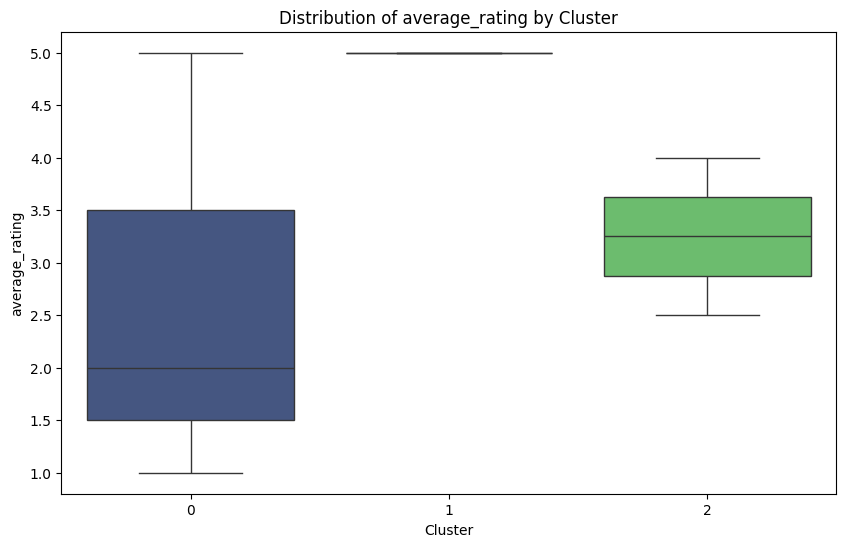

<ipython-input-53-ac9b53bb1f7b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=reviewer_group, palette='viridis')


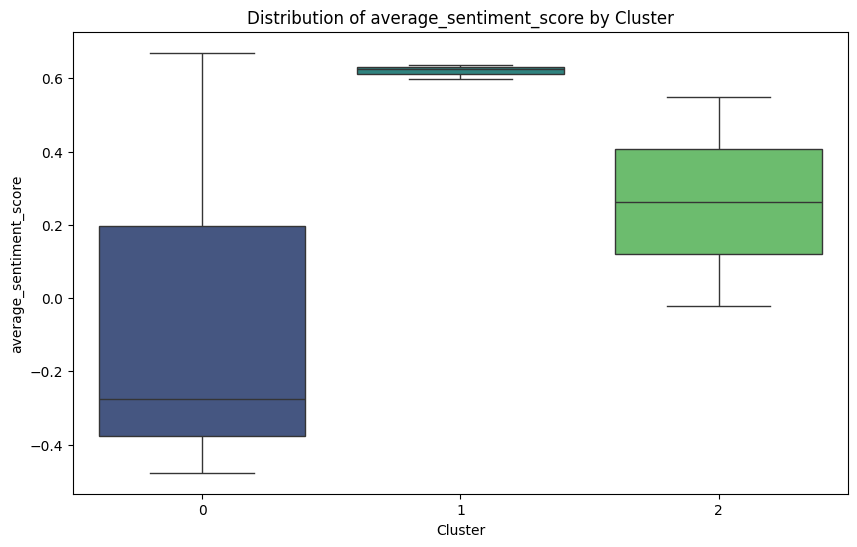

<ipython-input-53-ac9b53bb1f7b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=reviewer_group, palette='viridis')


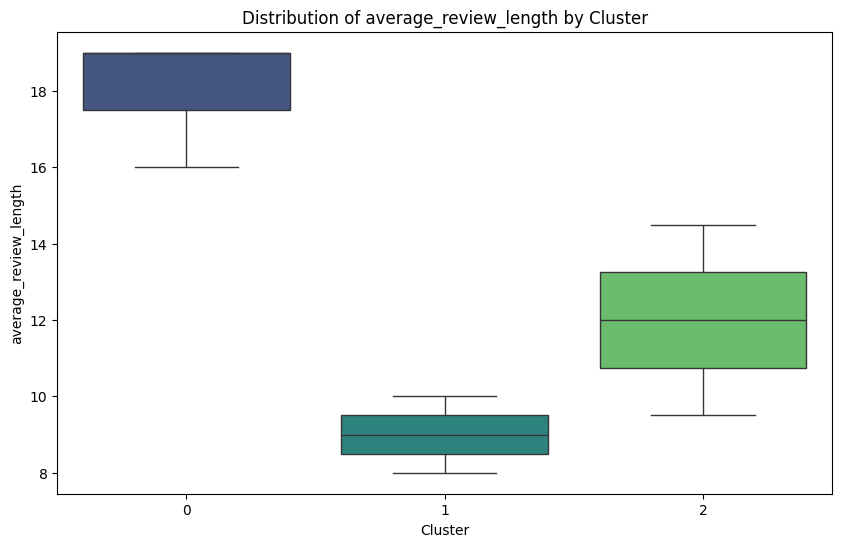

<ipython-input-53-ac9b53bb1f7b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=reviewer_group, palette='viridis')


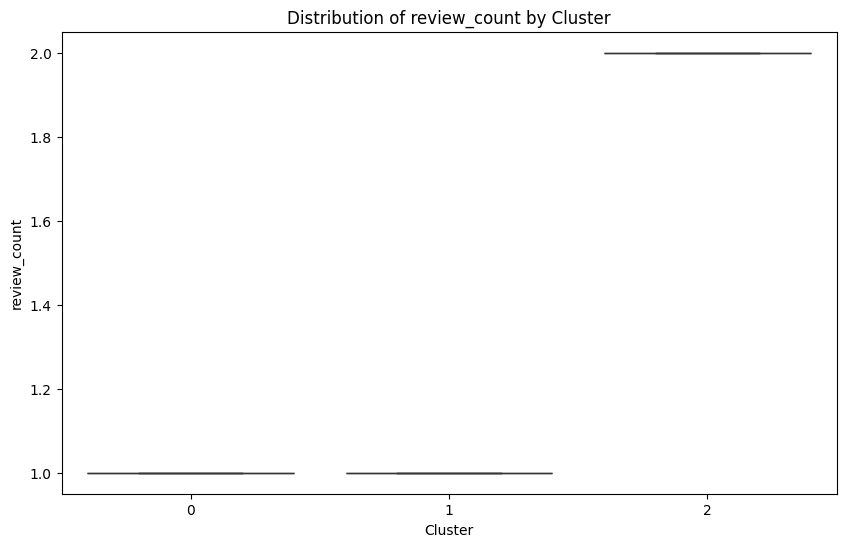

In [53]:

# Distribution of features for each cluster
for feature in ['average_rating', 'average_sentiment_score', 'average_review_length', 'review_count']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=reviewer_group, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

In [54]:
# Add cluster labels back to the original dataframe
df = df.merge(reviewer_group[['reviewers', 'cluster']], on='reviewers')

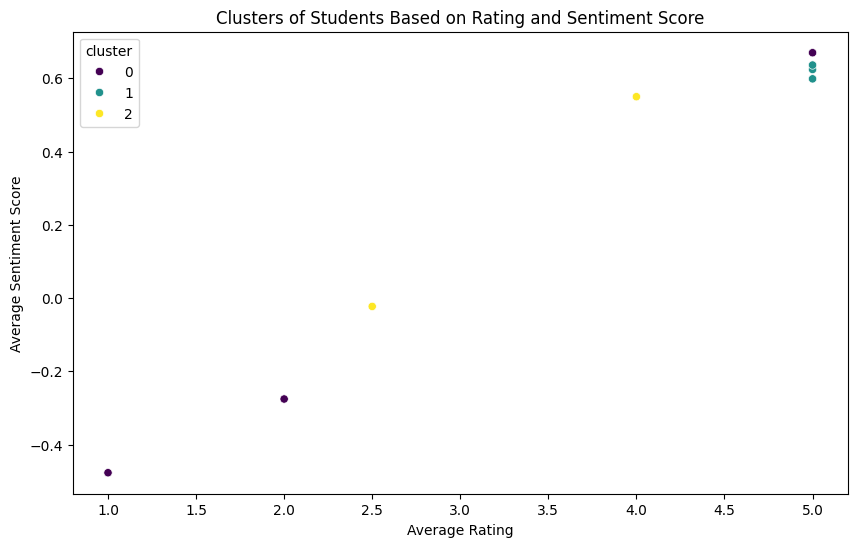

In [55]:
# Visualize clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_rating', y='average_sentiment_score', hue='cluster', data=reviewer_group, palette='viridis')
plt.title('Clusters of Students Based on Rating and Sentiment Score')
plt.xlabel('Average Rating')
plt.ylabel('Average Sentiment Score')
plt.show()


<ipython-input-56-b58fc0ada706>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=reviewer_group, palette='viridis')


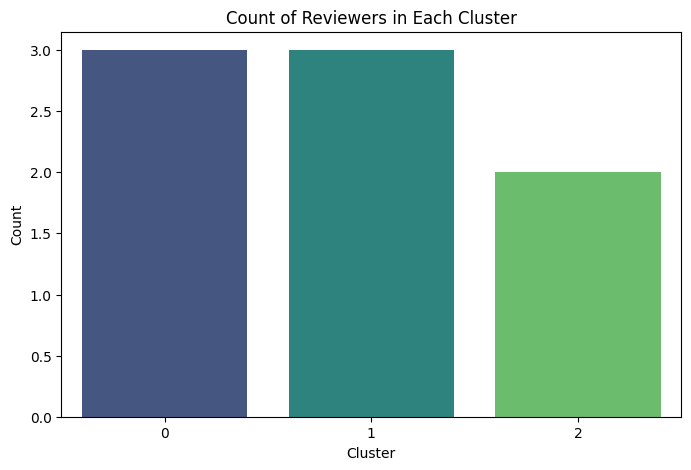

In [56]:
# Count of reviewers in each cluster
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=reviewer_group, palette='viridis')
plt.title('Count of Reviewers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [57]:
# Example function to preprocess and train the model
def train_model(X_train, y_train):
    # Initialize Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # Example of pipeline with TF-IDF vectorizer and Logistic Regression
    model = make_pipeline(
        TfidfVectorizer(max_features=1000),  # Example of vectorizer
        LogisticRegression()
    )

    # Fit the model on training data
    model.fit(X_train, y_train)

    return model

# Example training data and labels
X_train = [
    "This product is terrible.",
    "It exceeded my expectations.",
    "Very disappointed with the service.",
    "Amazing quality and fast delivery."
]
y_train = ['negative', 'positive', 'negative', 'positive']  # Example labels

# Train the model
model = train_model(X_train, y_train)

In [58]:
# Example function to preprocess and predict sentiment
def predict_sentiment(input_text, model):
    # Predict sentiment
    predicted_sentiment = model.predict([input_text])[0]

    # Example of sentiment score using VADER
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(input_text)['compound']

    # Adjust predicted sentiment based on sentiment score
    if sentiment_score > 0:
        predicted_sentiment = 'positive'
    elif sentiment_score < 0:
        predicted_sentiment = 'negative'
    else:
        predicted_sentiment = 'neutral'  # Handle neutral sentiment if needed

    return predicted_sentiment, sentiment_score

# Example input from user
input_text = "I really liked this product, it's great!"

# Predict sentiment using the trained model
predicted_sentiment, sentiment_score = predict_sentiment(input_text, model)

# Output the prediction and sentiment score
print(f"Input Text: {input_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Sentiment Score: {sentiment_score:.4f}")

Input Text: I really liked this product, it's great!
Predicted Sentiment: positive
Sentiment Score: 0.8169


In [59]:
# Example test data and labels
test_data = [
    "This product is terrible.",
    "It exceeded my expectations.",
    "Very disappointed with the service.",
    "Amazing quality and fast delivery."
]

# Example true labels corresponding to the test data
true_labels = ['negative', 'positive', 'negative', 'positive']  # Example labels

# Assuming model is already trained and stored in 'model'
predicted_labels = model.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


Confusion Matrix:
[[85  8]
 [21 86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        93
           1       0.91      0.80      0.86       107

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200



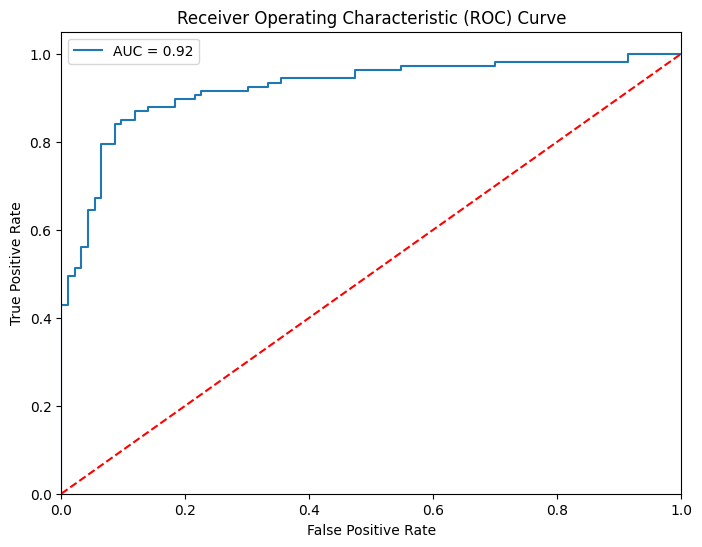

AUC Score: 0.9216


In [60]:
# Example: Generate synthetic data for demonstration
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example function to evaluate metrics
def evaluate_metrics(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve and AUC (for binary classification)
    if len(np.unique(y_test)) == 2:  # Check if binary classification
        y_scores = model.predict_proba(X_test)[:, 1]  # Probability of positive class
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)

        # Plot ROC Curve (optional)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()

        print(f"AUC Score: {auc_score:.4f}")

# Example usage
# Assuming 'model' is your trained model and 'X_test', 'y_test' are your test data
model = LogisticRegression()  # Example model, replace with your trained model
model.fit(X_train, y_train)  # Train the model on training data

evaluate_metrics(model, X_test, y_test)

In [61]:
#check for overfitting

def evaluate_model(model, X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

    # Print cross-validation scores
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

    # Fit the model on the whole training set
    model.fit(X_train, y_train)

    # Evaluate on the test set
    test_accuracy = model.score(X_test, y_test)
    print(f"Test Set Accuracy: {test_accuracy:.4f}")

    return cv_scores, test_accuracy

# Example usage
# Assuming 'model' is your trained model and 'X' is your feature matrix, 'y' is your target labels
cv_scores, test_accuracy = evaluate_model(model, X, y)

Cross-Validation Scores: [0.85625 0.875   0.85625 0.86875 0.88125]
Mean CV Accuracy: 0.8675
Test Set Accuracy: 0.8550
